<h1>Introduction</h1>
This notebook is used to calculate the following for a SPAUN model with 512-D semantic pointers that has been preprocessed to fit onto a Brainstorm chip.

| |Description|
|-|-|
|Total number of neurons|The total number of neurons in the SPAUN model<sup>1</sup>|
|Total number of ensembles|The total number of Ensembles in the SPAUN model|
|Total number of synapses|The total number of synapses in the SPAUN model.<sup>1</sup>|
|Total decoding weights|The total number of decoding weights.<sup>1</sup>|
|Total encoding weights|The total number of encoding weights.<sup>1</sup>|
|Total transform resource count| The total memory resources required for each Node to Node connection. The connection's associated weights must not be identity.|
|Compression|The ratio of the sum of total encoding weights, decoding weights and transform resource counts over total number of synapses|
|Average number of neurons per ensemble|The total number of neurons divided by the total number of ensembles.|
|Average number of synapses per neuron|The total number of synapses divided by the total number of neurons.|
|Average number of ensembles connected to|The average number of Ensembles that a given Ensemble is connected to.<sup>1</sup>|
<sup>1</sup>Calculation described in section below<br>
<h2>Total number of neurons</h2><br>
The total number of neurons is calculated as follows:<br>
$$
\sum_{i=1}^{NE} N_i
$$<br>
where NE is the number of ensembles in the model and N<sub>i</sub> is Ensemble i's neuron count.<br>
<h2>Total number of synapses</h2><br>
The total number of synapses is calculated as follows:<br><br>
$$
\sum_{i=1}^{NE} \sum_{j=1}^{F} N_i * N_{i,j}
$$<br>
where NE is the number of ensembles in the model, F is the number of Ensembles with inputs from Ensemble i, N<sub>i</sub> is Ensemble i's neuron count and N<sub>i,j</sub> is the neuron count for Ensemble j where Ensemble j is an Ensemble that receives input from Ensemble i.

<h2>Total decoding weights</h2><br>
The total number of decoding weights is determined for a model that has been preprocessed using Terry's preprocesing algorithm. The algorithm ensures that each Ensembles output is connnected to a subclass of Nengo Node called Decoder. Given this, each Ensembles decoding weight is calculated by multiplying the Ensembles neuron count by the Decoders output dimension count. The total decoding weights is calculated as follows:<br><br>
$$
\sum_{i=1}^{NE}  DecodingWeight(Ensemble[i])
$$<br>
where NE is the number of ensembles in the model and DecodingWeights(Ensemble[i]) returns Ensemble[i]'s decoding weight. The decoding weight being the Ensembles neuron count times the Ensemble Decoders output dimension count.<br>
<h2>Total encoding weights</h2><br>
The total number of encoding weights is determined for a model that has been preprocessed using Terry's preprocesing algorithm. The algorithm ensures that each Ensembles input is connnected to a subclass of Nengo Node called Encoder. Given this, each Ensembles encoding weight is calculated by multiplying the Ensembles neuron count by the Encoders input dimension count. The total encoding weights is calculated as follows:<br><br>
$$
\sum_{i=1}^{NE}  EncodingWeight(Ensemble[i])
$$<br>
where NE is the number of ensembles in the model and EncodingWeights(Ensemble[i]) returns Ensemble[i]'s encoding weight. The encoding weight being the Ensembles neuron count times the Ensemble Encoders input dimension count.<br>
<h2>Average fanout</h2><br>
The average fanout (or average number of Ensembles that a given Ensemble is connected to) is determined by creating a dictionary whose key is an Ensemble and whose value is a list of all Ensembles that a given Ensembles is connected to. The connected Ensembles are determined by "walking along" a given Ensembles connections until another Ensemble is reached. When another Ensembles is reached, the Ensembles is added to the list associated with the source Ensemble. The average is simply the average length of all lists in the dictionary.<br>

<h2>Notes</h2>
<h3>Repo's used</h3>
The following repo versions were used when calculating these numbers:<br>

github.com:Stanford-BIS/spaun2.0.git<br>
SHA ID: a9ac6fbb2b0e2046f1fc91ba653c341bba369c21


github.com:ctn-waterloo/nef-chip-hardware.git<br>
SHA ID: 99c3e42132a705b8283db2174425fbac6c6961e2

github.com:nengo/nengo.git<br>
SHA ID: a4e6cb6196e99b14d4165fab692d6b8eaab610cf

<h3>Specific settings in run_spaun.py</h3>
In the run_spaun.py script, the def_seq variable was assigned 'A1[#1]?XXX' and the seed was set to 1465947960.

<h3>Some initial numbers</h3>
We were initially assuming that there would be ~2.5 million neurons, 32K ensembles and ~8billion synapses.
After running the code with a 512D SPAUN network where all EnsembleArrays were flattened, we got the following results.

Total number of neurons = 3911430                                               
Total number of ensembles = 61134                                               
Total number of synapses = 123347780500                                         
Total fanout = 19346210                                                         
Total decoding weights = 8591230                                                
Total encoding weights = 932272                                                 
                                                                                
Average number of neurons per ensemble = 63.98                                  
Average number of synapses per neuron = 31535.00                                
Average fanout = 316.46       

In [1]:
%%capture
%run build_spaun_all_modules.py -d 4



In [2]:
import compute_stats as cp
cp.compute_stats(model)


Total number of neurons = 203030
Total number of ensembles = 2850
Total number of synapses = 118070500
Total fanout = 18301
Total decoding weights = 205830
Total encoding weights = 281530
Total transform resource count = 19212

Compression = 0.004290

Average number of neurons per ensemble = 71.24
Average number of synapses per neuron = 581.00
Average fanout = 6.42


# Simple communication channel
This section tests the compute_stats function with a simple communication channel network.
The network looks as follows:

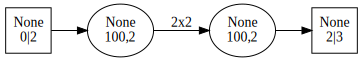

In [3]:
import nengo_brainstorm_pp.preprocessing as pp
from nengo_brainstorm import gv_utils
import numpy as np
import nengo

reload(gv_utils)

def make_fanout_network(fanout=1, use_identity_transforms=True):
    source_dims = 2
    dest_dims = 2
    n_neurons = 100
    comm_model = nengo.Network()
    with comm_model:
        a = nengo.Ensemble(n_neurons, source_dims)
        input_node = nengo.Node(np.random.randn(source_dims))
        nengo.Connection(input_node,a)
    
        def step(t,x):
            return 1,1,1
        for i in range(fanout):
            b = nengo.Ensemble(n_neurons, dest_dims)
            
            if use_identity_transforms==True:
                transform=np.identity(source_dims)
            else:
                transform=np.ones(shape=(source_dims, dest_dims), dtype=int)
                
            nengo.Connection(a,b,transform = transform)
            
            output_node = nengo.Node(step,size_in=2)
        
            nengo.Connection(b, output_node)
            
    return comm_model
        
comm_model = make_fanout_network(fanout=1,use_identity_transforms=True)
gv_utils.gv_plot(comm_model)

The nework has two Ensembles each composed of 100 neurons with 2 dimensional inputs and 2 dimensional outputs. 

The connection between the two Ensembles uses a non-identity transform.

The first Ensembles input and the second Ensembles output are connected to 2-dimensional Nodes.

Evaluating this network by hand, we would expect the total number of synapses to be 100*100=10000, the total memory resource count = 800 and the compression = 800 / 10000 = 0.08.

Total number of neurons = 200
Total number of ensembles = 2
Total number of synapses = 10000
Total fanout = 1
Total decoding weights = 400
Total encoding weights = 400
Total transform resource count = 0

Compression = 0.080000

Average number of neurons per ensemble = 100.00
Average number of synapses per neuron = 50.00
Average fanout = 0.50


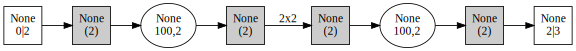

In [4]:
new_comm_model = pp.preprocess(comm_model,find_io = False)
cp.compute_stats(new_comm_model)
gv_utils.gv_plot(new_comm_model)

Our results match our expectations.

# Simple communication channel with non identity
Now what happens if we use a non-identity transform on the Connection between Ensembles.

The network structure is the same as above, however, since the transform is now a non-identity transform.

Using this network, we expect the total number of synapses to be 100*100=10000, the total memory resource count to be 804 (since the transform now consumes 4 units) and the compression to be 0.0804.

Total number of neurons = 200
Total number of ensembles = 2
Total number of synapses = 10000
Total fanout = 1
Total decoding weights = 400
Total encoding weights = 400
Total transform resource count = 4

Compression = 0.080400

Average number of neurons per ensemble = 100.00
Average number of synapses per neuron = 50.00
Average fanout = 0.50


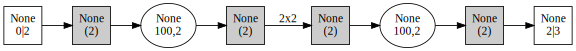

In [5]:
comm_model = make_fanout_network(fanout=1, use_identity_transforms=False)
new_comm_model = pp.preprocess(comm_model,find_io = False)
cp.compute_stats(new_comm_model)
gv_utils.gv_plot(new_comm_model)

Again, we get what we expect.

# Simple communication channel with fanout
Now what happens if an Ensemble is connected to several Ensembles.

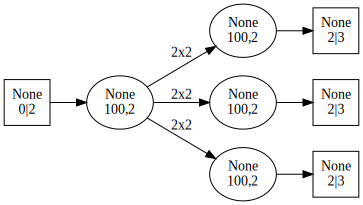

In [6]:
comm_model = make_fanout_network(fanout=3, use_identity_transforms=False)
gv_utils.gv_plot(comm_model)

The network is composed of an Ensemble connected to three Ensembles using non-identity transforms.

The preprocessed network would look as follows.

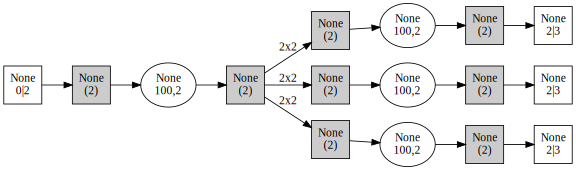

In [7]:
new_comm_model = pp.preprocess(comm_model,find_io = False)
gv_utils.gv_plot(new_comm_model)

The total memory resource count is determined by calculating the total encoding weight, total decoding weight and total transform resource count as follows. First, there are 4 Ensembles each with 100 neurons and 2 encoding dimensions so the total encoding weight count equals 4 * 2 * 100 = 800. Similarly, the total decoding weight count also equals $4 * 2 * 100 = 800$. Finally, since there are 3 connections from a source Ensemble to 3 destination Ensembles and each Connection has 2 input and 2 output dimensions, the total transform resource count equals 3 * 2 * 2 = 12. So, the total memory resource count equals 800 + 800 + 12 = 1612.

The total synapse count is calculated by multiplying the number of neurons from a source Ensemble to a destination Ensemble for each pair of connected Ensembles. Since there are 3 pairs of connected Ensembles and each Ensemble has 100 neurons, the total synapse count equals 3 * 100 * 100 = 30000.

Given the total synapse count and the total memory resource count, the compression = 1612 / 30000 = 0.0537.

Does this jive?

In [9]:
cp.compute_stats(new_comm_model)

Total number of neurons = 400
Total number of ensembles = 4
Total number of synapses = 30000
Total fanout = 3
Total decoding weights = 800
Total encoding weights = 800
Total transform resource count = 12

Compression = 0.053733

Average number of neurons per ensemble = 100.00
Average number of synapses per neuron = 75.00
Average fanout = 0.75


Yes it does.

# Simple fanin with non-identity
Networks with fanout structures works but what about networks with fanin structures?

Let's create a network where 13 Ensembles fanin to a single destination Ensemble.

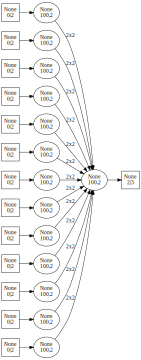

In [10]:
def make_fanin_network(fanin=1, use_identity_transforms=True):
    source_dims = 2
    dest_dims = 2
    n_neurons = 100
    comm_model = nengo.Network()
    with comm_model:
        def step(t,x):
            return 1,1,1
        
        a = nengo.Ensemble(n_neurons, source_dims)
        output_node = nengo.Node(step,size_in=2)
        nengo.Connection(a,output_node)
    
        for i in range(fanin):
            b = nengo.Ensemble(n_neurons, dest_dims)
            
            if use_identity_transforms==True:
                transform=np.identity(source_dims)
            else:
                transform=np.ones(shape=(source_dims, dest_dims), dtype=int)
                
            nengo.Connection(b,a,transform = transform)
            
            input_node = nengo.Node(np.random.randn(source_dims))
        
            nengo.Connection(input_node,b)
    return comm_model

comm_model = make_fanin_network(fanin=13, use_identity_transforms=False)
gv_utils.gv_plot(comm_model)

As before, we can calculate the total memory resource count and the total synapse count. Given these two values, we can calculate the compression.

The total memory resource count is determined by calculating the total encoding weight, total decoding weight and total transform resource count as follows. First, there are 14 Ensembles each with 100 neurons and 2 encoding dimensions so the total encoding weight count equals $14 * 2 * 100 = 2800$. Similarly, the total decoding weight count also equals $14 * 2 * 100 = 2800$. Finally, since there are 13 connections from a source Ensemble to single destination Ensemble and each Connection has 2 input and 2 output dimensions, so the total transform resource count equals $13 * 2 * 2 = 52$. So, the total memory resource count equals $2800 + 2800 + 52 = 5652$.

The total synapse count is calculated by multiplying the number of neurons from a source Ensemble to a destination Ensemble for each pair of connected Ensembles. Since there are 13 pairs of connected Ensembles and each Ensemble has 100 neurons, the total synapse count equals $13 * 100 * 100 = 130000$.

Given the total synapse count and the total memory resource count, the compression equals $5652 / 130000 = 0.0435$.

Does this jive?

In [11]:
new_comm_model = pp.preprocess(comm_model,find_io = False)
cp.compute_stats(new_comm_model)


Total number of neurons = 1400
Total number of ensembles = 14
Total number of synapses = 130000
Total fanout = 13
Total decoding weights = 2800
Total encoding weights = 2800
Total transform resource count = 52

Compression = 0.043477

Average number of neurons per ensemble = 100.00
Average number of synapses per neuron = 92.00
Average fanout = 0.93


Yes it does!

# Circular convolution network
What about a more complicated network like the circular convolution network used in Spaun.

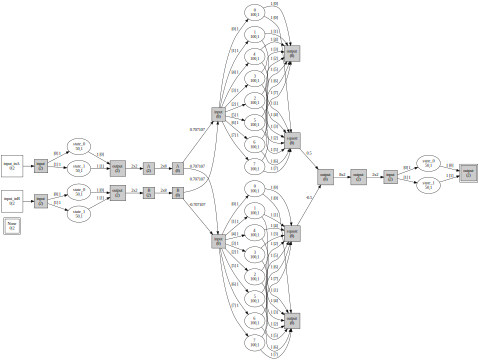

In [12]:
import nengo.spa as spa

def make_conv_network(dims=8,subdims=2,pstc=0.01):
    model = spa.SPA()                                                       
    with model:                                                             
        model.inA = spa.Buffer(dims, subdimensions=subdims)                     
        model.inB = spa.Buffer(dims, subdimensions=subdims)                     
                                                                                
        model.result = spa.Buffer(dims, subdimensions=subdims)                  
                                                                                
        model.cortical = spa.Cortical(spa.Actions('result = inA * inB'),       
                                      synapse=pstc)                       
                                                                                
        model.input = spa.Input(inA='A', inB='B')                           
                                                                                
        probe = nengo.Probe(model.result.state.output, synapse=pstc) 
                                                                                
        ideal = nengo.Node(model.get_output_vocab('inA').parse('A*B').v)       
        probe_ideal = nengo.Probe(ideal, synapse=None)                 
    return model                                                
conv_model = make_conv_network(dims=2,subdims=1)
gv_utils.gv_plot(conv_model)

If we preprocess the network, we get the following.

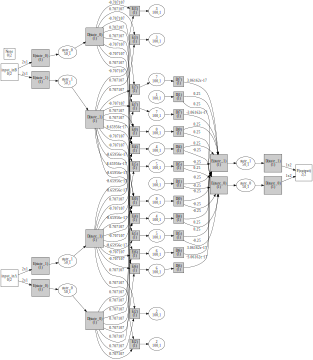

In [13]:
new_conv_model = pp.preprocess(conv_model,find_io = False)
gv_utils.gv_plot(new_conv_model)

Now, as before, we determine the compression by calculating the total synapse count and the total memory
resource count. To determine the total memory resource count, we start by calculating the total encoding
weight. We see that there are 6 Ensembles with 50 neurons and inputs from 1 dimensional nodes as well 14 Ensembles with 100 neurons with inputs from 1 dimensional nodes. Using these numbers, we calculate total encoding weights to be $(6*1*50) + (14*1*100) = 1700$.
We next compute the total decoding weights. We see that there are 6 Ensembles with 50 neurons and outputs to 1 dimensional nodes as well as 12 Ensembles with 100 neurons and outputs to 1 dimensional nodes. Using these numbers, we calculate total decoding weights to be $(6*1*50) + (12*1*100) = 1500$.
Finally, we compute the total transform resource count. We notice that each Node-Node connection a non-identity transfrom as well as one dimension input and one dimension output; therefore, the total tranform count can be determined by simply counting the number of Node-Node connections which totals 60.
The total memory resource count is $1700+1500+60=3260$.
The total synapse count is determined by considering each path from an Ensemble to an Ensemble and multiplying the number of neurons in the source Ensemble by the number of neurons in the destination Ensemble. When evaluating the network above, we notice the following:
* two 50 neuron source Ensembles have 8 connections to 100 neuron destination Ensembles totalling $2*8*(50*100)=80000$.
* two 50 neuron source Ensembles have 12 connections to 100 neuron destination Ensembles totalling $2*12*(50*100)=120000$.
* four 100 neuron source Ensembles have 1 connection to 50 neuron destination Ensembles totalling $4*1*(100*50)=20000$.
* eight 100 neuron source Ensembles have 2 connections to 50 neuron destination Ensembles totalling $8*2*(100*50)=80000$.
Therefore, the total synapse count equals $80000+120000+20000+80000=300000$.
Given the total memory resource count and the total synapse count, the compression equals $3260/300000=0.0109$.

In [14]:
cp.compute_stats(new_conv_model)


Total number of neurons = 1900
Total number of ensembles = 22
Total number of synapses = 300000
Total fanout = 60
Total decoding weights = 1500
Total encoding weights = 1700
Total transform resource count = 60

Compression = 0.010867

Average number of neurons per ensemble = 86.36
Average number of synapses per neuron = 157.00
Average fanout = 2.73


This jives!